In [4]:
class LDA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.linear_discriminants = None

    def dot_product(self, a, b):
        # Calculate dot product of two vectors
        result = 0
        for i in range(len(a)):
            result += a[i] * b[i]
        return result

    def matrix_multiply(self, A, B):
        # Multiply two matrices
        result = []
        for i in range(len(A)):
            row = []
            for j in range(len(B[0])):
                entry = 0
                for k in range(len(B)):
                    entry += A[i][k] * B[k][j]
                row.append(entry)
            result.append(row)
        return result

    def subtract_vectors(self, a, b):
        # Subtract one vector from another
        result = []
        for i in range(len(a)):
            result.append(a[i] - b[i])
        return result

    def transpose_matrix(self, A):
        # Transpose a matrix
        result = []
        for i in range(len(A[0])):
            row = []
            for j in range(len(A)):
                row.append(A[j][i])
            result.append(row)
        return result

    def fit(self, X, y):
        n_features = len(X[0])
        class_labels = list(set(y))
        mean_overall = [sum(col) / len(col) for col in zip(*X)]
        S_W = [[0] * n_features for _ in range(n_features)]
        S_B = [[0] * n_features for _ in range(n_features)]

        for c in class_labels:
            X_c = [X[i] for i in range(len(X)) if y[i] == c]
            mean_c = [sum(col) / len(col) for col in zip(*X_c)]
            X_c_mean_diff = [self.subtract_vectors(x, mean_c) for x in X_c]

            X_c_mean_diff_transposed = self.transpose_matrix(X_c_mean_diff)
            S_W_temp = self.matrix_multiply(X_c_mean_diff_transposed, X_c_mean_diff)
            for i in range(n_features):
                for j in range(n_features):
                    S_W[i][j] += S_W_temp[i][j]

            n_c = len(X_c)
            mean_diff = self.subtract_vectors(mean_c, mean_overall)
            mean_diff = [[mean_diff[i]] for i in range(n_features)]
            S_B_temp = self.matrix_multiply(mean_diff, self.transpose_matrix(mean_diff))
            for i in range(n_features):
                for j in range(n_features):
                    S_B[i][j] += n_c * S_B_temp[i][j]
        
        print("S_W:")
        for row in S_W:
            print(row)
        print("\nS_B:")
        for row in S_B:
            print(row)
            
        A = self.matrix_multiply(self.matrix_inverse(S_W), S_B)
        print("\nMatrix A:")
        for row in A:
            print(row)
        eigenvalues, eigenvectors = self.eigen(A)
        idxs = sorted(range(len(eigenvalues)), key=lambda k: abs(eigenvalues[k]), reverse=True)
        eigenvalues = [eigenvalues[i] for i in idxs]
        eigenvectors = [eigenvectors[i] for i in idxs]
        
        # Sort eigenvalues and eigenvectors in descending order
        idxs = sorted(range(len(eigenvalues)), key=lambda k: abs(eigenvalues[k]), reverse=True)
        eigenvalues = [eigenvalues[i] for i in idxs]
        eigenvectors = [eigenvectors[i] for i in idxs]
        
        print("\nEigenvalues:")
        print(eigenvalues)
        print("\nEigenvectors:")
        for row in eigenvectors:
            print(row)
        
        self.linear_discriminants = eigenvectors[0:self.n_components]
        
        print("\nSelected Linear Discriminants:")
        for row in self.linear_discriminants:
            print(row)
        
    def matrix_inverse(self, A):
        # Calculate the inverse of a matrix
        n = len(A)
        identity = [[1 if i == j else 0 for j in range(n)] for i in range(n)]
        for i in range(n):
            factor = 1.0 / A[i][i]
            for j in range(n):
                A[i][j] *= factor
                identity[i][j] *= factor
            for k in range(n):
                if k != i:
                    factor = -A[k][i]
                    for j in range(n):
                        A[k][j] += factor * A[i][j]
                        identity[k][j] += factor * identity[i][j]
        return identity

    def eigen(self, A):
        # Calculate eigenvalues and eigenvectors of a matrix
        n = len(A)
        eigenvalues = [0] * n
        eigenvectors = [[0] * n for _ in range(n)]
        for i in range(n):
            eigenvectors[i][i] = 1.0
        for iteration in range(50):  
            max_element = 0.0
            for i in range(n):
                for j in range(i + 1, n):
                    if abs(A[i][j]) >= max_element:
                        max_element = abs(A[i][j])
                        p = i
                        q = j
            if max_element < 1e-6:
                break
            phi = 0.5 * (eigenvalues[q] - eigenvalues[p]) / A[p][q]
            t = 1.0 / (abs(phi) + (phi ** 2 + 1) ** 0.5)
            if phi < 0:
                t = -t
            c = 1.0 / (t ** 2 + 1) ** 0.5
            s = t * c
            tau = s / (1.0 + c)
            temp = A[p][q]
            A[p][q] = 0.0
            eigenvalues[p] -= t * temp
            eigenvalues[q] += t * temp
            for j in range(p):
                temp = A[j][p]
                A[j][p] = temp - s * (A[j][q] + tau * temp)
                A[j][q] = A[j][q] + s * (temp - tau * A[j][q])
            for j in range(p + 1, q):
                temp = A[p][j]
                A[p][j] = temp - s * (A[j][q] + tau * A[p][j])
                A[j][q] = A[j][q] + s * (temp - tau * A[j][q])
            for j in range(q + 1, n):
                temp = A[p][j]
                A[p][j] = temp - s * (A[q][j] + tau * temp)
                A[q][j] = A[q][j] + s * (temp - tau * A[q][j])
            for j in range(n):
                temp = eigenvectors[j][p]
                eigenvectors[j][p] = c * temp - s * eigenvectors[j][q]
                eigenvectors[j][q] = s * temp + c * eigenvectors[j][q]
        return eigenvalues, eigenvectors
    
    def transform(self, X):
        # Project data
        transformed_data = self.matrix_multiply(X, self.transpose_matrix(self.linear_discriminants))
        return transformed_data


S_W:
[38.956199999999995, 13.629999999999995, 24.624600000000008, 5.645000000000001]
[13.629999999999995, 16.962000000000003, 8.1208, 4.808400000000001]
[24.624600000000008, 8.1208, 27.222600000000014, 6.271800000000001]
[5.645000000000001, 4.808400000000001, 6.271800000000001, 6.156599999999999]

S_B:
[63.21213333333327, -19.952666666666712, 165.2483999999999, 71.27933333333328]
[-19.952666666666712, 11.344933333333353, -57.239600000000095, -22.93266666666671]
[165.2483999999999, -57.239600000000095, 437.1027999999999, 186.774]
[71.27933333333328, -22.93266666666671, 186.774, 80.41333333333333]

Matrix A:
[-3.058369391467149, 1.0813826444329433, -8.11192270231929, -3.4586498723459913]
[-5.561639262673131, 2.178218663075758, -14.964611937241008, -6.307739505812649]
[8.077438781883153, -2.9427185421935214, 21.511590900731637, 9.142064681969188]
[10.497081867684773, -3.419854491293057, 27.548524816037006, 11.845880068560836]

Eigenvalues:
[23.228206603592007, -16.76684201887626, -5.56817

C:\Users\laksh\AppData\Local\Temp\ipykernel_16840\2764224113.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  axs[0].scatter(X[:, 0], X[:, 1], c=y, edgecolor='none', alpha=0.8, cmap=plt.cm.get_cmap('viridis', 3))
C:\Users\laksh\AppData\Local\Temp\ipykernel_16840\2764224113.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  axs[1].scatter(x1, x2, c=y, edgecolor='none', alpha=0.8, cmap=plt.cm.get_cmap('viridis', 3))


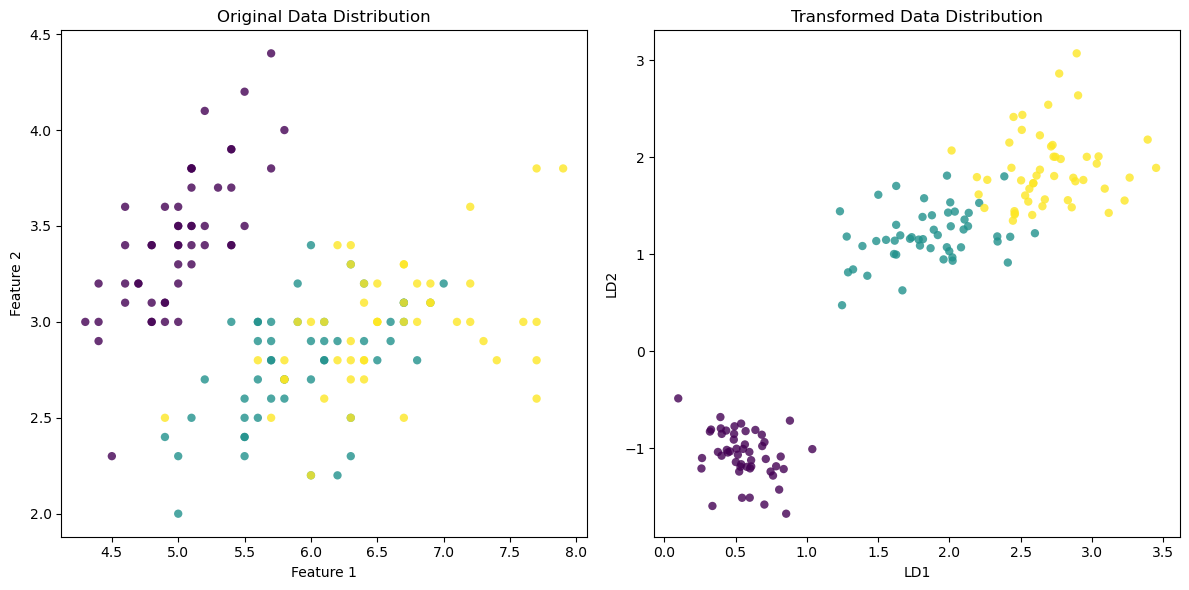

In [5]:
from sklearn import datasets
import matplotlib.pyplot as plt


data = datasets.load_iris()
X = data.data
y = data.target

lda = LDA(n_components=2)
lda.fit(X, y)

X_projected = lda.transform(X)


fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotting original data distribution
axs[0].scatter(X[:, 0], X[:, 1], c=y, edgecolor='none', alpha=0.8, cmap=plt.cm.get_cmap('viridis', 3))
axs[0].set_title('Original Data Distribution')
axs[0].set_xlabel('Feature 1')
axs[0].set_ylabel('Feature 2')

# Plotting transformed data distribution
x1 = [X_projected[i][0] for i in range(len(X_projected))]
x2 = [X_projected[i][1] for i in range(len(X_projected))]
axs[1].scatter(x1, x2, c=y, edgecolor='none', alpha=0.8, cmap=plt.cm.get_cmap('viridis', 3))
axs[1].set_title('Transformed Data Distribution')
axs[1].set_xlabel('LD1')
axs[1].set_ylabel('LD2')

plt.tight_layout()
plt.show()